In [4]:
from datetime import datetime, timedelta
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [5]:
js = pd.read_json('data/virus_world.json')
countries = ['us','italy','china']



								  - - -  SLOPE  - - - 
								 us : 0.288
								 italy : 0.206
								 china : 0.288


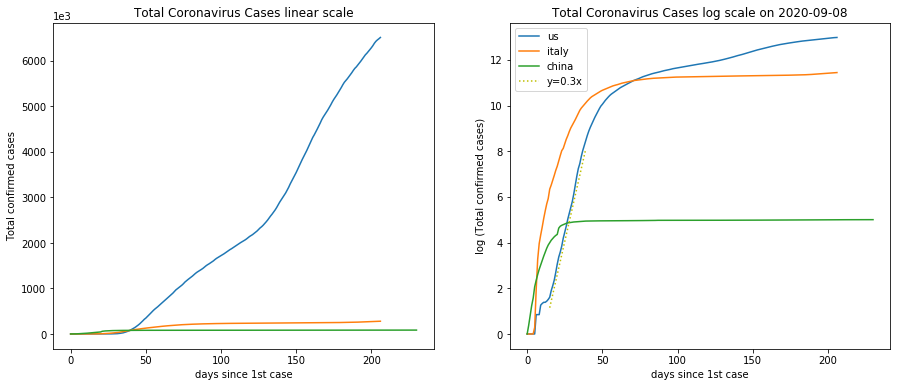

In [20]:
def linear_regression(y,c):
    '''lack of data in the beginning for china'''
    gap = 14
    lr = LinearRegression(fit_intercept=True)
    m  = 0
    i0 = 0
    if c == 'italy':
        i0 = 14
    for i in range(i0,len(y),gap):
        y_ = y[i:i+gap]
        x_ = np.arange(1,len(y_)+1)
        x_ = x_.reshape(-1,1)
        y_ = y_.reshape(-1,1)
        lr.fit(x_, y_)
        m = max(m,lr.coef_[0][0])
    return m

def plot_total_cases(countries):
    """LOG SCALE"""
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

    for c in countries:
        dt = np.array([datetime.strptime('2020 '+d,'%Y %b%d') for d in js[c]['date']])
        i  = np.arange(len(js[c]['date']))
        j  = i[15:40]  # section used for linear regression
        y1 = np.array(js[c]['total'])
        y2 = np.log(y1/y1[0]) 
        m  = linear_regression(y2,c)
        print ('\t'*8,'%s : %.3f'%(c,m))
        


        ax1.plot(i,y1,label=c)
        ax2.plot(i,y2,label=c)
        
    date = str(dt[-1])[0:10]  
    ax2.plot(j,j*0.29-3.2,'y:',label='y=0.3x')

    ax1.set_xlabel('days since 1st case')
    ax1.set_ylabel('Total confirmed cases')
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(3,3))
    ax1.set_title('Total Coronavirus Cases linear scale')
    
    ax2.legend()
    ax2.set_xlabel('days since 1st case')
    ax2.set_ylabel('log (Total confirmed cases)')
    ax2.set_title('Total Coronavirus Cases log scale on '+date )


    plt.show()
    
print ('\t'*8,' - - -  SLOPE  - - - ')
    
plot_total_cases(countries)

My first intuition of the graph is that the data probably follows an exponential trend, as the infection rates went up very quickly. 

So let's test our first model, defining I as infection population and assuming each patient passes on to *A* number of new people everyday. I can test it by  by plotting ln(y) against t, and the slope will be ln(a), figure 2 :  \begin{equation} \label{0}
I = I_{0}\times A^{t}
\end{equation}





However in figure2 (ln(y) vs t), it looks a bit like a straight line at the early days and not so much later. After doing some research, I found that scientist often divide population into two groups: infected and susceptible. To simplify, let's define population as 1 and I(t) is the percentage of population that is infected

\begin{equation} \label{1}
S(t)+I(t) = 1
\end{equation}


Very often, the rate of infection of a disease is affected by both infection and susceptible population. To consider two extreme cases, 
- when s = 1 , i = 0, the transmission rate, $\beta$ = 0
- when s = 0 , i = 1, everyone is infected and no more new cases, $\beta$ = 0 


\begin{equation} \label{2}
\frac{dI}{dt} = - \frac{dS}{dt} = \beta S I
\end{equation}



This is equation is an ODE function, and we can solve it using Python




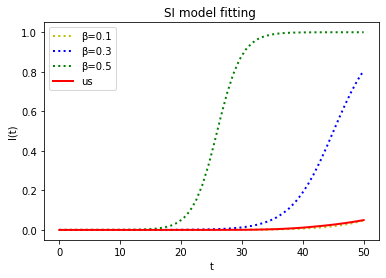

In [9]:
from datetime import datetime, timedelta
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

js = pd.read_json('data/virus_world.json')
def model(y,t,k):
    dy_dt = k*y*(1-y)
    return dy_dt

def SI_model(c):
    v = np.array(js[c]['total'])
    v = v/(np.max(v))
    y0 = v[0]

    t = np.linspace(0,50)

    
    # solve ODEs
    k1,k2,k3 = 0.2,0.288,0.5
    y1 = odeint(model,y0,t,args=(k1,))
    y2 = odeint(model,y0,t,args=(k2,))
    y3 = odeint(model,y0,t,args=(k3,))

    # plot results
    plt.plot(t,y1,'y:',linewidth=2,label='β=0.1')
    plt.plot(t,y2,'b:',linewidth=2,label='β=0.3')
    plt.plot(t,y3,'g:',linewidth=2,label='β=0.5')
    d = min(len(t),len(v))
    plt.plot(t[0:d],v[:d],'r',linewidth=2,label=c)
    
    plt.xlabel('t')
    plt.ylabel('I(t)')
    plt.legend()
    plt.title('SI model fitting ')

    plt.show()
    
SI_model(c='us')


/Users/mumuxi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


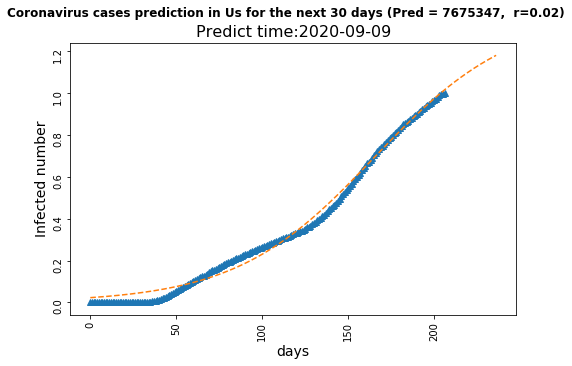

In [11]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
 
def logistic_function(t, K, P0, r):
    exp = np.exp(-r * t)
    return 1 / (K + (exp+1) * P0)
 
def prediction(c):

    predict_days = 30
    data = pd.read_json('data/virus_world.json')[c]
    confirm = np.array(data['total'])
    scaler = np.max(confirm)
    confirm = confirm/(scaler)


    x = np.arange(len(confirm))
    # curve fit
    popt, pcov = curve_fit(logistic_function, x, confirm,maxfev=2000)
    #predit future
    predict_x = list(x) + [x[-1] + i for i in range(1, 1 + predict_days)]
    predict_x = np.array(predict_x)
    predict_y = logistic_function(predict_x, popt[0], popt[1], popt[2])
    plt.figure(figsize=(8, 5))
    plt.plot(x, confirm, '^',label="confimed infected number")
    plt.plot(predict_x, predict_y, '--',label="predicted infected number")
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)

    plt.suptitle("Coronavirus cases prediction in %s for the next %d days (Pred = %d,  r=%.2f)"%(c.capitalize(),predict_days,scaler*predict_y[-1], popt[2]), fontsize=12, fontweight="bold")
    plt.title("Predict time:{}".format(time.strftime("%Y-%m-%d", time.localtime())), fontsize=16)
    plt.xlabel('days', fontsize=14)
    plt.ylabel('Infected number', fontsize=14)
    plt.show()
    
prediction(c='us')